<a href="https://colab.research.google.com/github/chrismartel/COMP551/blob/main/projects/p2/diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mini-Project 2: Optimization and Text Classification**

## **Project Setup**

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd ~/.ssh/
!ssh-keygen -t rsa -b 4096
!ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts
%cd /root/.ssh
!cat id_rsa.pub
# then, copy key to github account

[Errno 2] No such file or directory: '/root/.ssh/'
/content
Generating public/private rsa key pair.
Enter file in which to save the key (/root/.ssh/id_rsa): 
Created directory '/root/.ssh'.
Enter passphrase (empty for no passphrase): 
Enter same passphrase again: 
Your identification has been saved in /root/.ssh/id_rsa.
Your public key has been saved in /root/.ssh/id_rsa.pub.
The key fingerprint is:
SHA256:Yp+ht+s5RHYrZOw6IC2NV8S30Hwt7xeNKmKbrvtYnSM root@a6718082b4b9
The key's randomart image is:
+---[RSA 4096]----+
|     . o   .     |
|      + + o .    |
|     . + o o   o |
|      . B . . o .|
|   + .o*S. o . . |
|  + =. +*+o.o .  |
|   + ..+E=+. .   |
|      o+++ .     |
|      +BBo       |
+----[SHA256]-----+
# github.com:22 SSH-2.0-babeld-3c627260
/root/.ssh
ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAACAQCzsvUAp28p1MbMqkdQYT+G+484NOdzJtQ1Xxr5a+BlPCvUBzXKkb/F3sPDmMQMCuUGfFlkBzJKINybjIjQu35tpzX3TUKNEE0HjROT6mFmvhLRZvwIqNQZbDSZzxY+gQu34nDNGBB8Bl/ceJJD/Wr+W9S2v+/g+7HruY8AjtXPON1ZgyfKmW8KATlZfqB

In [2]:
#%cd /content/drive/MyDrive/git/COMP551/projects/p2
#%cd /content/drive/MyDrive/Git/COMP551/projects/p2

/content/drive/MyDrive/git/COMP551/projects/p2


In [3]:
import pandas as pd
import numpy as np
import time
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from random import randint
np.random.seed(1234)

## **PART I: Optimaztion**

### **Import Data**

In [4]:
train_df, test_df, val_df = pd.read_csv('data/diabetes/diabetes_train.csv'), pd.read_csv('data/diabetes/diabetes_test.csv'),pd.read_csv('data/diabetes/diabetes_val.csv')
x_train, y_train = train_df.iloc[:,:-1].to_numpy(), train_df.iloc[:,-1].to_numpy()
x_test, y_test = test_df.iloc[:,:-1].to_numpy(), test_df.iloc[:,-1].to_numpy()
x_val, y_val = val_df.iloc[:,:-1].to_numpy(), val_df.iloc[:,-1].to_numpy()

### **1. Logisitic regression, learning rate and number of training iterations**
You should first start by running the logistic regression code using the given implementation. This will serve as a baseline for the following steps. Find a learning rate and a number of training iterations such that the model has fully converged to a solution. Make sure to provide empirical evidence supporting your decision (e.g. training and validation accuracy as a function of number of training iterations).

#### **1.1 Logistic Regression**
We leverage the Logisitic Regression notebook which can be found here: 

https://github.com/mravanba/comp551-notebooks/blob/master/LogisticRegression.ipynb

The Logisitic Regression class is modified to allow for stochastic gradient and momentum.

In [41]:
logistic = lambda z: 1./ (1 + np.exp(-z))   #logistic function

class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False, batch_size=None, momentum=False, momentum_coefficient=0.9):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose
        self.gradient_norm = np.inf
        self.batch_size = batch_size
        self.momentum = momentum

        if self.momentum:
          # array to store gradient of each time step
          self.gradients = [0] * max_iters
          self.momentum_coefficient = momentum_coefficient

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        # gradient
        g = np.inf 
        # timestamp
        t = 0
        # the code snippet below is for gradient descent
        while self.gradient_norm > self.epsilon and t < self.max_iters:
            g = self.stochastic_gradient(x, y, self.batch_size)

            if self.momentum:
              self.gradients[t] = g

            self.gradient_norm = np.linalg.norm(g)

            if self.momentum and t != 0:
              self.w = self.w -self.learning_rate * self.running_average(t)
            else:
              self.w = self.w - self.learning_rate * g 

            t += 1
        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh

    def stochastic_gradient(self, x, y, batch_size=None):
        N = x.shape[0]
        if batch_size is None or batch_size > N:              # gradient on full data by default
          batch_size = N
        inds = np.random.permutation(N)
        x_batch = x[inds,:][:batch_size,:]
        y_batch = y[inds][:batch_size]
        yh = logistic(np.dot(x_batch, self.w))
        stoch_grad = np.dot(x_batch.T,yh - y_batch)/batch_size
        return stoch_grad

    def running_average(self, t):
      running_average = 0
      for i in range(1,t+1):
          running_average += (self.momentum_coefficient ** (t-i)) * (1-self.momentum_coefficient) * self.gradients[i]
      return running_average


#### **1.2 Metrics**

In [6]:
def accuracy(y, yh):
    return np.sum(y == yh)/y.size

def cost_fn(x, w, y, add_bias=False):
    N, D = x.shape                                                       
    if add_bias:
      x = np.column_stack([x,np.ones(N)])
    z = np.dot(x, w)
    J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies 
    return J

#### **1.3 Gradient Descent Hyper-Parameter Tuning**

Method used to visualize the training and validation accuracy convergence/divergence when increasing the maximum number of gradient descent iterations for different learning rates.

In [49]:
def gd_hypertuning_plots(param_range_type = 'lr', param_range = None, max_iters_range=np.arange(0,100,1), x_train=None, y_train=None, x_val=None, y_val=None, reg_type='logistic', lr=0.001, batch_size=None, momentum=False, momentum_coefficient=None):
  '''
  param_range_type: the code of the parameter we want to tune. 
                    'lr': learning rate
                    'bs': batch size
                    'mc': momentum coefficient

  param_range: the range of the param we want to tune

  max_iters_range: the rage of number of gradient descent iterations

  x_train, y_train, x_val, y_val: the data

  reg_type: type of regression to use

  lr: fixed learning rate to use when tuning other parameters

  batch_size: fixed batch size to use when tuning other parameters

  momentum: indicates if momentum gradient descent is used 

  momentum_coefficient: fixed momentum coefficient to use when tuning other parameters
  '''
  
  # setup figures and axis
  figure, axis = plt.subplots(3, 2)
  figure.set_figheight(10)
  figure.set_figwidth(10)
  figure.tight_layout(pad=5.0)

  # figure title
  if param_range_type == 'lr':
    param_name = 'Learning Rate'
    label_format = "%0.6f"
  elif param_range_type == 'bs':
    param_name = 'Batch Size'
    label_format = "%d"
  elif param_range_type == 'mc':
    param_name = 'Momentum Coefficient'
    label_format = "%0.6f"

  figure.suptitle('Convergence of Gradient Descent Solution for Different {param}'.format(param=param_name), fontsize=16)
  axis[0][0].set_title("Train Cross-Entropy Loss")
  axis[0][0].set_ylabel("Cost")

  axis[1][0].set_title("Validation Cross-Entropy Loss")
  axis[1][0].set_ylabel("Cost")

  axis[0][1].set_title("Train Accuracy")
  axis[0][1].set_ylabel("Cost")

  axis[1][1].set_title("Validation Accuracy")
  axis[1][1].set_ylabel("Cost")

  axis[2][0].set_title("Gradient Norm")
  axis[2][0].set_ylabel("Gradient Norm")

  axis[2][1].set_title("Execution Time")
  axis[2][1].set_ylabel("Time")

  min_train_cost, min_val_cost = {'value':np.inf, 'max_iters':0, 'param':0}, {'value':np.inf, 'max_iters':0, 'param':0}
  max_train_acc, max_val_acc = {'value':0, 'max_iters':0, 'param':0}, {'value':0, 'max_iters':0, 'param':0}

  for i,  param in enumerate(param_range):
    
    # setup param we want to tune
    if param_range_type == 'lr':
      lr = param
    elif param_range_type == 'bs':
      batch_size = param
    elif param_range_type == 'mc':
      momentum_coefficient = param

    # y axis ranges
    train_cost_arr = np.zeros((max_iters_range.size))
    val_cost_arr = np.zeros((max_iters_range.size))

    train_acc_arr = np.zeros((max_iters_range.size))
    val_acc_arr = np.zeros((max_iters_range.size))

    g_norm_arr = np.zeros((max_iters_range.size))
    time_arr = np.zeros((max_iters_range.size))

    for j, max_iters in enumerate(max_iters_range):
      t0 = time.time()
      if reg_type == 'logistic':
        reg = LogisticRegression(add_bias=True, learning_rate=lr, epsilon=1e-4, max_iters=max_iters, verbose=False, batch_size=batch_size, momentum=momentum, momentum_coefficient=momentum_coefficient)
      reg.fit(x_train, y_train)
 
      t1 = time.time()
      time_arr[j] = t1 - t0
      train_cost_arr[j], val_cost_arr[j] = cost_fn(x_train, reg.w, y_train, add_bias=True), cost_fn(x_val, reg.w, y_val, add_bias=True)
      yh_train, yh_val = reg.predict(x_train), reg.predict(x_val)
      train_acc_arr[j], val_acc_arr[j] = accuracy(y_train, np.rint(yh_train)), accuracy(y_val, np.rint(yh_val))
      g_norm_arr[j] = reg.gradient_norm

    # keep track of best scores
    cur_min_train_cost, cur_min_val_cost = np.min(train_cost_arr), np.min(val_cost_arr)
    cur_max_train_acc, cur_max_val_acc = np.max(train_acc_arr), np.max(val_acc_arr)

    if cur_min_train_cost < min_train_cost['value']:
      min_train_cost['value'] = cur_min_train_cost
      min_train_cost['max_iters'] = max_iters_range[np.argmin(train_cost_arr)]
      min_train_cost['param'] = param

    if cur_min_val_cost < min_val_cost['value']:
      min_val_cost['value'] = cur_min_val_cost
      min_val_cost['max_iters'] = max_iters_range[np.argmin(val_cost_arr)]
      min_val_cost['param'] = param

    if cur_max_train_acc > max_train_acc['value']:
      max_train_acc['value'] = cur_max_train_acc
      max_train_acc['max_iters'] = max_iters_range[np.argmax(train_acc_arr)]
      max_train_acc['param'] = param

    if cur_max_val_acc > max_val_acc['value']:
      max_val_acc['value'] = cur_max_val_acc
      max_val_acc['max_iters'] = max_iters_range[np.argmax(val_acc_arr)]
      max_val_acc['param'] = param

    # add plot lines
    axis[0][0].plot(max_iters_range, train_cost_arr, label=label_format % param)
    axis[1][0].plot(max_iters_range, val_cost_arr, label=label_format % param)
    axis[0][1].plot(max_iters_range, train_acc_arr, label=label_format % param)
    axis[1][1].plot(max_iters_range, val_acc_arr, label=label_format % param)
    axis[2][0].plot(max_iters_range, g_norm_arr, label=label_format % param)
    axis[2][1].plot(max_iters_range, time_arr, label=label_format % param)

  for subplot in axis.reshape(-1):
    subplot.set_xlabel("Number of Iterations")
    subplot.legend()
  plt.show()

  print("Minimal train cost: {cost}\n{param_name}: {param}\nNumber of iterations: {max_iters}\n".format(cost=min_train_cost['value'], param_name=param_name, param=min_train_cost['param'], max_iters=min_train_cost['max_iters']))
  print("Minimal validation cost: {cost}\n{param_name}: {param}\nNumber of iterations: {max_iters}\n".format(cost=min_val_cost['value'], param_name=param_name, param=min_val_cost['param'], max_iters=min_val_cost['max_iters']))

  print("Maximal train accuracy: {acc}\n{param_name}: {param}\nNumber of iterations: {max_iters}\n".format(acc=max_train_acc['value'], param_name=param_name, param=max_train_acc['param'], max_iters=max_train_acc['max_iters']))
  print("Maximal validation accuracy: {acc}\n{param_name}: {param}\nNumber of iterations: {max_iters}\n".format(acc=max_val_acc['value'], param_name=param_name, param=max_val_acc['param'], max_iters=max_val_acc['max_iters']))





#### **1.4 Learning Rate and Number of Iterations Tuning**

The learning rate and the max number of iterations will be determined empirically. We will start by high learning rates. The accuracy per number of iterations will be plot for each learning rate. If we see that the accuracy oscillates and does not converge to a value, it means that our learning is too high.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


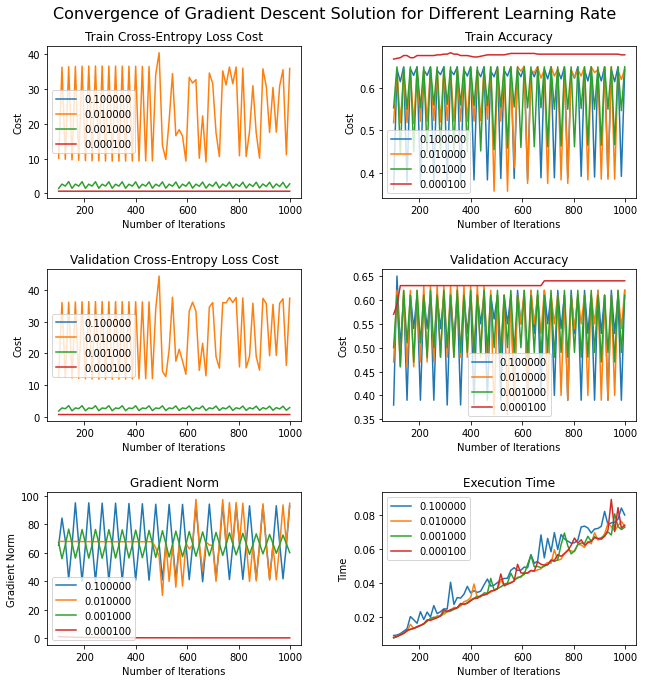

Minimal train cost: 0.6141635036765292
Learning Rate: 0.0001
Number of iterations: 997

Minimal validation cost: 0.6580063027306937
Learning Rate: 0.0001
Number of iterations: 165

Maximal train accuracy: 0.6833333333333333
Learning Rate: 0.0001
Number of iterations: 321

Maximal validation accuracy: 0.65
Learning Rate: 0.1
Number of iterations: 113



In [46]:
lr_range = np.array([0.1,0.01,0.001, 0.0001])
max_iters_range = np.arange(100,1000,13)
gd_hypertuning_plots(param_range_type = 'lr', param_range = lr_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.001, batch_size=None, momentum=False, momentum_coefficient=None)

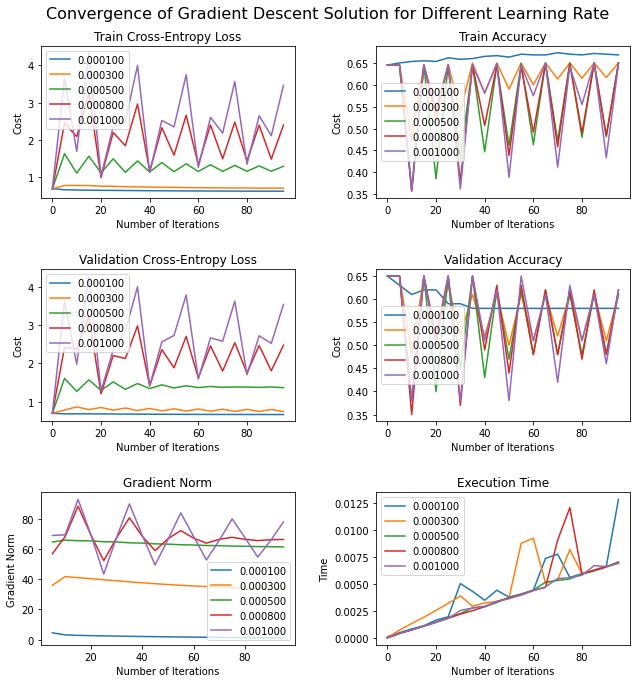

Minimal train cost: 0.6258820840080458
Learning Rate: 0.0001
Number of iterations: 95

Minimal validation cost: 0.6595322623185856
Learning Rate: 0.0001
Number of iterations: 95

Maximal train accuracy: 0.6733333333333333
Learning Rate: 0.0001
Number of iterations: 70

Maximal validation accuracy: 0.65
Learning Rate: 0.0001
Number of iterations: 0



In [48]:
lr_range = np.array([0.0001,0.0003, 0.0005, 0.0008, 0.001])
max_iters_range = np.arange(0,100,5)
gd_hypertuning_plots(param_range_type = 'lr', param_range = lr_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.001, batch_size=None, momentum=False, momentum_coefficient=None)

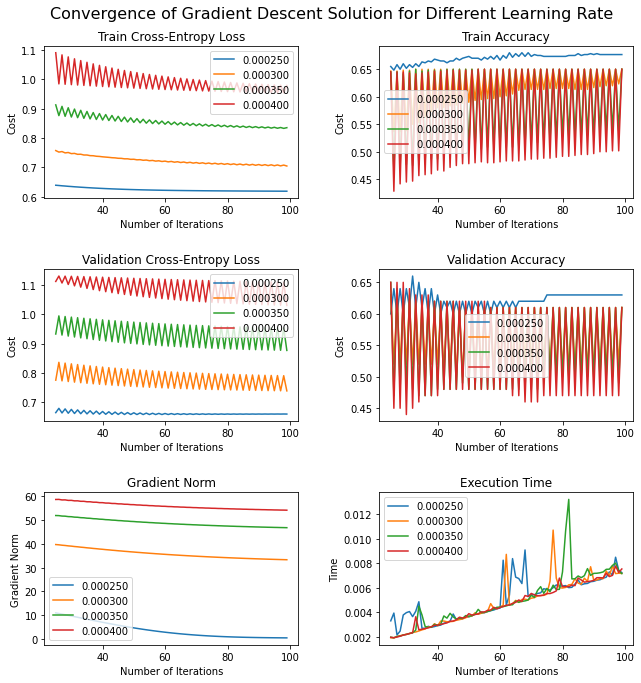

Minimal train cost: 0.6184746555144273
Learning Rate: 0.00025
Number of iterations: 99

Minimal validation cost: 0.6567508292236195
Learning Rate: 0.00025
Number of iterations: 55

Maximal train accuracy: 0.68
Learning Rate: 0.00025
Number of iterations: 63

Maximal validation accuracy: 0.66
Learning Rate: 0.00025
Number of iterations: 32



In [50]:
lr_range = np.array([0.00025, 0.0003, 0.00035, 0.0004])
max_iters_range = np.arange(25,100,1)
gd_hypertuning_plots(param_range_type = 'lr', param_range = lr_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.001, batch_size=None, momentum=False, momentum_coefficient=None)

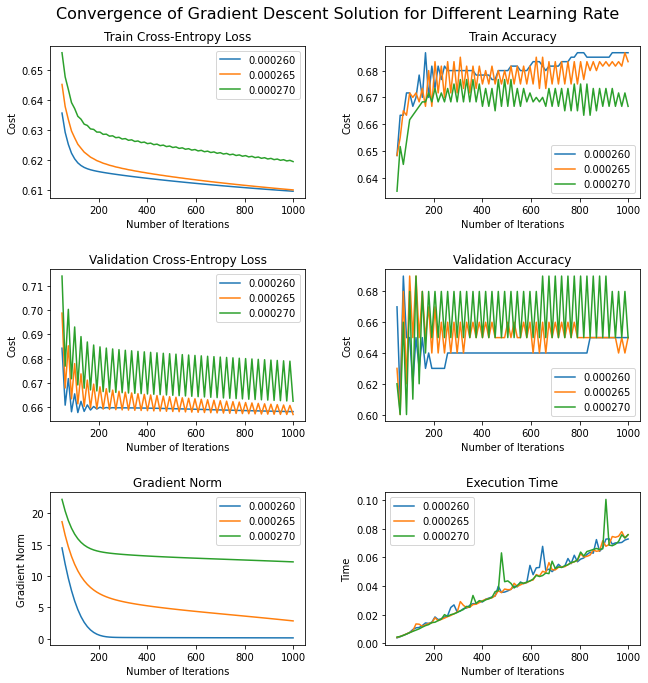

Minimal train cost: 0.6097105522790539
Learning Rate: 0.00026
Number of iterations: 999

Minimal validation cost: 0.6568726900422897
Learning Rate: 0.000265
Number of iterations: 999

Maximal train accuracy: 0.6866666666666666
Learning Rate: 0.00026
Number of iterations: 167

Maximal validation accuracy: 0.69
Learning Rate: 0.00026
Number of iterations: 76



In [52]:
lr_range = np.array([0.00026,0.000265, 0.00027])
max_iters_range = np.arange(50,1000,13)
gd_hypertuning_plots(param_range_type = 'lr', param_range = lr_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.001, batch_size=None, momentum=False, momentum_coefficient=None)

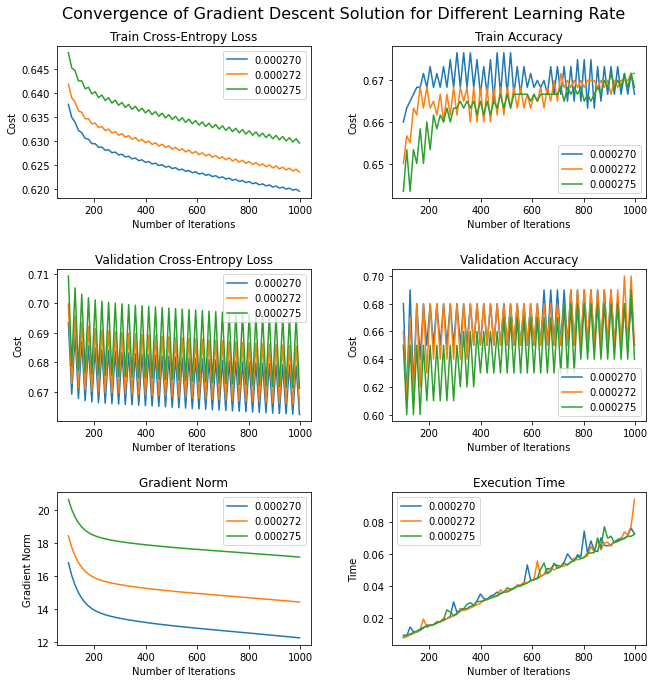

Minimal train cost: 0.6195939253948656
Learning Rate: 0.00027
Number of iterations: 997

Minimal validation cost: 0.662376638741873
Learning Rate: 0.00027
Number of iterations: 997

Maximal train accuracy: 0.6766666666666666
Learning Rate: 0.00027
Number of iterations: 308

Maximal validation accuracy: 0.7
Learning Rate: 0.000272
Number of iterations: 958



In [53]:
lr_range = np.array([0.00027,.000272, 0.000275])
max_iters_range = np.arange(100,1000,13)
gd_hypertuning_plots(param_range_type = 'lr', param_range = lr_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.001, batch_size=None, momentum=False, momentum_coefficient=None)

#### **1.5 Results**

From the empirically testing, we decided to use a learning rate of 0.000271 and a maximum number of iterations of 3 000 000.

In [57]:
lr = 0.000272
max_iters = 2000000
epsilon = 0.01

reg = LogisticRegression(add_bias=True, learning_rate=lr, epsilon=epsilon, max_iters=max_iters, verbose=True, momentum=False, momentum_coefficient=0.9, batch_size=None)
reg.fit(x_train, y_train)

# compute error
yh_train, yh_val, yh_test = reg.predict(x_train), reg.predict(x_val), reg.predict(x_test)
y_pred_train, y_pred_val, y_pred_test = np.rint(yh_train), np.rint(yh_val), np.rint(yh_test)
acc_train, acc_val, acc_test = accuracy(y_train, y_pred_train), accuracy(y_val, y_pred_val), accuracy(y_test, y_pred_test)

print("train accuracy: {acc_train}".format(acc_train=acc_train))
print("validation accuracy: {acc_val}".format(acc_val=acc_val))
print("test accuracy: {acc_test}".format(acc_test=acc_test))

terminated after 1005496 iterations, with norm of the gradient equal to 0.009999996626856099
the weight found: [ 1.31495597e-01  2.74292663e-02 -1.70700631e-02 -2.71391944e-03
  2.10107786e-04  5.10398665e-02  5.95659400e-01  2.93698807e-03
 -5.31192259e+00]
train accuracy: 0.7716666666666666
validation accuracy: 0.75
test accuracy: 0.7647058823529411


### **2. Mini-batch Sochastic Gradient**

Implement mini-batch stochastic gradient descent. Then, using growing minibatch sizes (e.g. 8, 16, 32, ...) compare the convergence speed and the quality of the final solution to the fully batched baseline. What configuration works the best among the ones you tried ?

Best train accuracy: 0.69
Batch Size: 8
Number of iterations: 85

Best validation accuracy: 0.71
Batch Size: 32
Number of iterations: 72



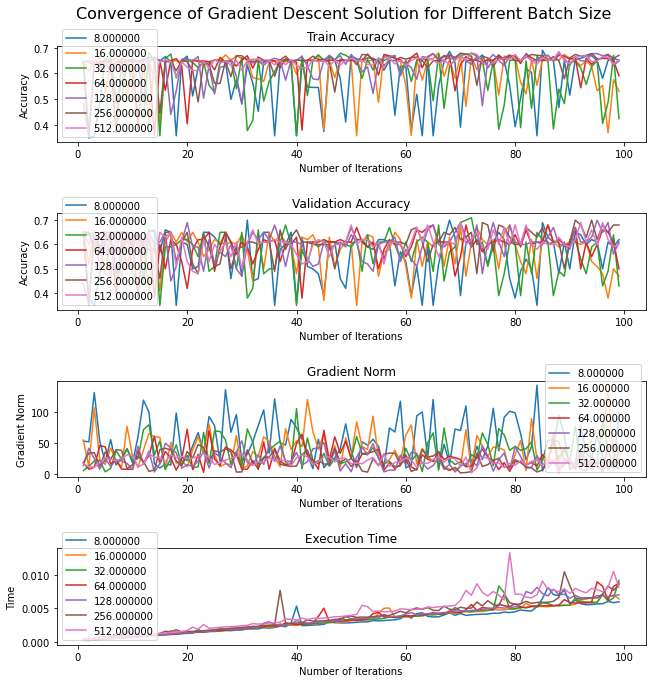

In [ ]:
batch_size_range = [8, 16, 32, 64, 128, 256, 512]

max_iters_range = np.arange(1,100,1)
gd_hypertuning_plots(param_range_type = 'bs', param_range = batch_size_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=lr, batch_size=None, momentum=False, momentum_coefficient=None)

### **3. Gradient Descent with Momentum**

Add momentum to the gradient descent implementation. Trying multiple values for the momentum coefficient, how does it compare to regular gradient descent ? Specifically, analyze the impact of momentum on the convergence speed and the quality of the final solution.

Vary the momentum coefficient and check effect on convergence speed.

No batch size --> full data

Best train accuracy: 0.6833333333333333
Momentum Coefficient: 0.99
Number of iterations: 96

Best validation accuracy: 0.65
Momentum Coefficient: 0.5
Number of iterations: 1



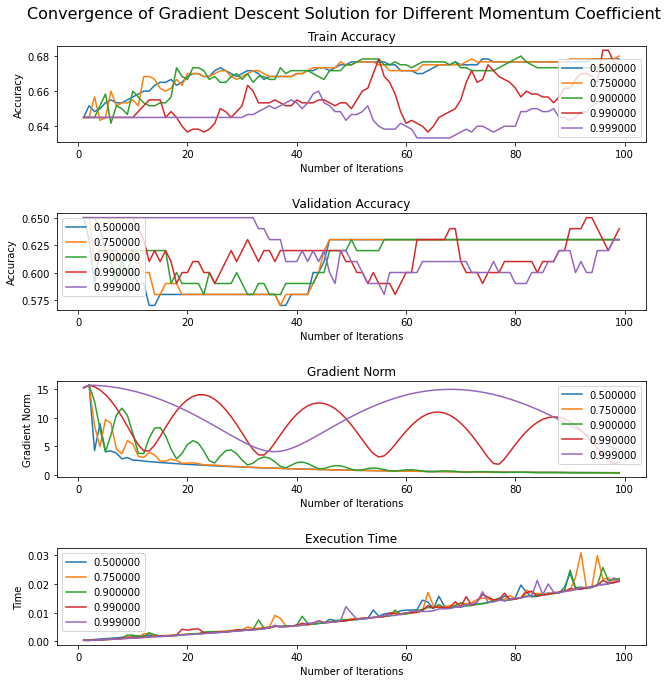

In [ ]:
momentum_coefficient_range = [0.5, 0.75, 0.9, 0.99, 0.999]
max_iters_range = np.arange(1,100,1)
gd_hypertuning_plots(param_range_type = 'mc', param_range = momentum_coefficient_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=lr, batch_size=None, momentum=True, momentum_coefficient=None)

### **4. Gradient Descent with Momentum using smallest and largest batch sizes from 2)**

Repeat the previous step for a) the smallest batch size and b) largest batch size you tried in 2). In which setting (small mini-batch, large mini-batch, fully batched) is it the most / least effective ?


Best train accuracy: 0.69
Momentum Coefficient: 0.9
Number of iterations: 96

Best validation accuracy: 0.71
Momentum Coefficient: 0.9
Number of iterations: 72



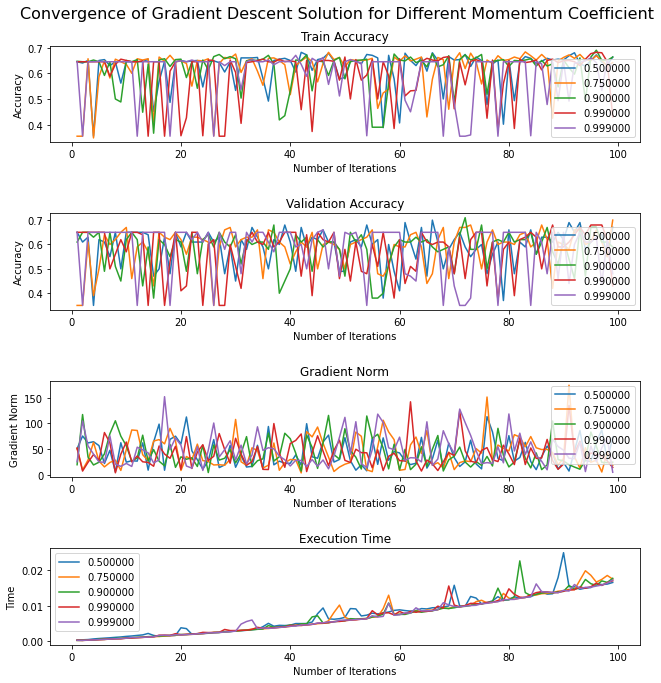

In [ ]:
momentum_coefficient_range = [0.5, 0.75, 0.9, 0.99, 0.999]
max_iters_range = np.arange(1,100,1)

min_bs = 8
gd_hypertuning_plots(param_range_type = 'mc', param_range = momentum_coefficient_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=lr, batch_size=min_bs, momentum=True, momentum_coefficient=None)


Best train accuracy: 0.685
Momentum Coefficient: 0.75
Number of iterations: 94

Best validation accuracy: 0.6599999999999999
Momentum Coefficient: 0.99
Number of iterations: 70



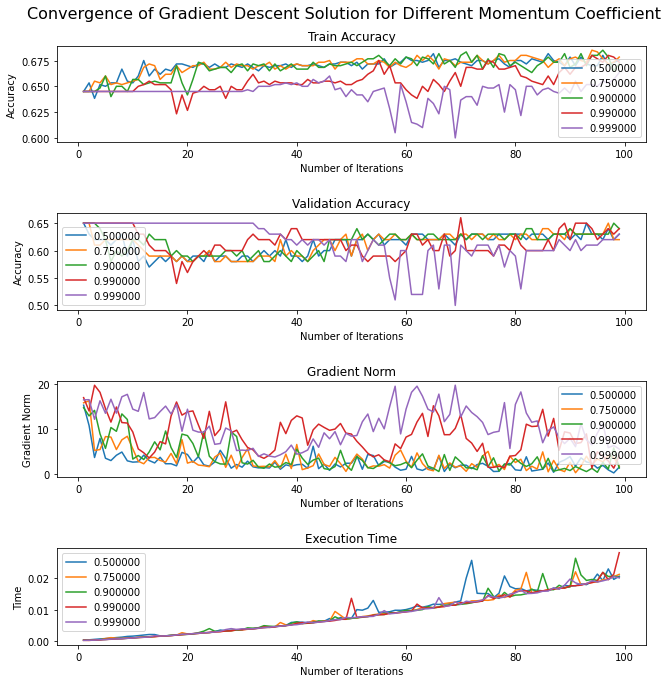

In [ ]:
momentum_coefficient_range = [0.5, 0.75, 0.9, 0.99, 0.999]
max_iters_range = np.arange(1,100,1)

max_bs = 512
gd_hypertuning_plots(param_range_type = 'mc', param_range = momentum_coefficient_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=lr, batch_size=max_bs, momentum=True, momentum_coefficient=None)

## **PART II: Text Classification**